# Introduction

## Preprocessing

In the following section we describe the most significant steps during data preprocessing. For simplicity reasons, the final (cleaned) `csv` file is included together with the notebook.

Main steps:
- unifying all the separate `csv` files into one
- geocoding and augmentation, correction of manual errors in the original dataset (e.g. wrong coordinates)
- clustering into different geographical locations and evaluation with silhouette coefficient

In the geocoding step, we focus on adding coordinates to entries collected from 2006 to mid-2013. We achieve this by querying a Nominatim API (hosted on a docker container) in order to recover the coordinates associated to each road/location. \
In some cases, however, the search yields no results, so we create a script to fill empty coordinates with values obtained from similar entries....

## Classification

In this section we focus on trying to predict ....



In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Dependencies and Reproducibility

In [1]:
#@title Install Pyspark

!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 4.9 MB/s eta 0:00:00a 0:00:01


In [2]:
#@title Install Folium

!pip install folium plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 9.9 MB/s eta 0:00:00:00:0100:01


In [3]:
#@title Import dependencies


#General dependencies

import plotly.express as px
import numpy as np
from PIL import Image

#Geopandas
import folium

#Pyspark

import pyspark
import pyspark.pandas as ps
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import IntegerType,BooleanType,DateType

In [4]:
#@title Create Pyspark context

# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '10G').set('spark.driver.memory', '26G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [5]:
#@title Run this to ensure reproducibility

SEED = 413

# Data Preprocessing

In [ ]:
#@title Unzip dataset

#![[ ! -f aggregate.csv ]] && 7z x drive/MyDrive/aggregate.7z
#!7z x aggregate.7z

In [6]:
#@title Load dataset into memory
accidents_df = spark.read.csv("aggregate.csv", 
                               sep = ",",
                              header = True,
                              inferSchema = True)

In [7]:
#@title FIXME: Hacks to include in preprocessing.py

#Exclude coordinate outside Lazio
accidents_df = accidents_df.filter((41.220224002262036 < accidents_df['Latitude']) & (accidents_df['Latitude'] < 42.82125541042326))
accidents_df = accidents_df.filter((11.774008325698063 < accidents_df['Longitude']) & (accidents_df['Longitude'] < 14.029342839702176))

accidents_df = accidents_df.withColumn('Deadly', accidents_df['NUM_MORTI'] > 0)
accidents_df = accidents_df.withColumn('Injured', accidents_df['NUM_FERITI'] > 0)

accidents_df = accidents_df.withColumn('NUM_FERITI', accidents_df.NUM_FERITI.cast(IntegerType()))

accidents_df = accidents_df.drop('Unnamed: 37')

In [9]:
#@title Visualize the csv's schema

accidents_df.printSchema()

root
 |-- Protocollo: integer (nullable = true)
 |-- Gruppo: integer (nullable = true)
 |-- DataOraIncidente: string (nullable = true)
 |-- DaSpecificare: string (nullable = true)
 |-- NaturaIncidente: string (nullable = true)
 |-- particolaritastrade: string (nullable = true)
 |-- TipoStrada: string (nullable = true)
 |-- FondoStradale: string (nullable = true)
 |-- Pavimentazione: string (nullable = true)
 |-- Segnaletica: string (nullable = true)
 |-- CondizioneAtmosferica: string (nullable = true)
 |-- Traffico: string (nullable = true)
 |-- Visibilita: string (nullable = true)
 |-- Illuminazione: string (nullable = true)
 |-- NUM_FERITI: integer (nullable = true)
 |-- NUM_RISERVATA: integer (nullable = true)
 |-- NUM_MORTI: integer (nullable = true)
 |-- NUM_ILLESI: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Confermato: double (nullable = true)
 |-- Progressivo: double (nullable = true)
 |-- TipoVeicolo: string (

In [ ]:
#@title Visualize first five rows

accidents_df.show(5, truncate=True)

In [8]:
#@title Visualize a map of the accidents {run : "auto"}

#Obtain a map centered on Rome with Folium
map = folium.Map(location=(41.8974, 12.5022))
limit = 199 #@param {type:"slider", min:1, max:500} 


#Gather accidents' coordinates
accidents_coordinates = accidents_df['Latitude', 'Longitude'].limit(limit).collect()
for row in accidents_coordinates:

    point = [row['Latitude'], row['Longitude']]
    folium.Marker(location=point).add_to(map)

#Add coordinates popup
map.add_child(folium.LatLngPopup())

map

# Clustering

In [8]:
#@title Clustering functions

from pyspark.ml.feature import VectorAssembler

def compute_clusters(df, n_clusters, features=['Latitude', 'Longitude'], 
                     prediction_col='cluster', max_iterations=10):

  #SparkML expects columns to an instance of Linalg.Vector
  assembler = VectorAssembler().setInputCols(features).setOutputCol('features')
  assembled_df = assembler.transform(df)

  #Create KMeans instance
  kmeans = pyspark.ml.clustering.KMeans(k = n_clusters, featuresCol = 'features',
                                        predictionCol = prediction_col)

  #Set kmeans seed
  kmeans.setSeed(SEED)

  #Set maximum iterations
  kmeans.setMaxIter(max_iterations)
  #kmeans.getMaxIter()

  #Fit the model
  model = kmeans.fit(assembled_df)

  #Return the chosen distance measure (euclidean hopefully)
  #model.getDistanceMeasure()

  #Output a prediction for the first entry in the dataset
  model.predict(assembled_df.head().features)

  #Output centers of the model
  #centers = model.clusterCenters()
  #len(centers)

  #Output transformed df
  transformed = model.transform(assembled_df)
  return (model, transformed)


def evaluate_k_means(clusters, metric_name="silhouette", distance_measure="squaredEuclidean",
                     prediction_col="cluster"):
    from pyspark.ml.evaluation import ClusteringEvaluator

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(metricName=metric_name, distanceMeasure=distance_measure, predictionCol=prediction_col)

    score = evaluator.evaluate(clusters)
    del evaluator
    return score

def find_best_clustering(df, max_clusters, threshold=0.001):


  """Finds best clustering model w.r.t. the given metric and 
  returns both the model, the transformed dataframe and the scores"""

  # Evaluate for 2 clusters to get initial metrics
  best_model, best_transformed = compute_clusters(df, 5)
  best_score = evaluate_k_means(best_transformed)
  scores = [best_score]

  for k in range(10, max_clusters, 10):

      print("Using {} clusters".format(k))
      model, transformed = compute_clusters(df, k)
      score = evaluate_k_means(transformed)
      scores.append(score)
      if score > best_score:

        #Delete unused models to save space
        del best_model
        del best_transformed
        
        #Compute the difference between the previous and the new score
        delta = best_score - score

        best_score = score
        best_model = model
        best_transformed = transformed

        #if delta < threshold:
        #  break
        #else:
        del model
        del transformed

  return (best_model, best_transformed, scores)

In [9]:
#@title Find best clustering

max_clusters = 101 #@param {type: "slider", min:2, max:500}
model, clustered_df, clustering_scores = find_best_clustering(accidents_df, max_clusters)

Using 10 clusters
Using 20 clusters
Using 30 clusters
Using 40 clusters
Using 50 clusters
Using 60 clusters
Using 70 clusters
Using 80 clusters
Using 90 clusters
Using 100 clusters


In [10]:
#@title Visualize a map of the accidents per cluster {run : "auto"}

#Utility function
def assign_random_color(number):
  color_list =  ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
  return color_list[number % len(color_list)]

#Obtain a map centered on Rome with Folium
map = folium.Map(location=(41.8974, 12.5022))
limit = 27 #@param {type:"slider", min:1, max:10000} 

n_clusters = model.summary.k

for cluster_number in range(n_clusters):
  #Filter entries by cluster
  filtered_by_cluster = clustered_df.filter(clustered_df['cluster'] == cluster_number)

  #Gather accidents' coordinates
  coordinates_list = filtered_by_cluster['Latitude', 'Longitude'].limit(limit).collect()

  #Assign color for the markers
  color = assign_random_color(cluster_number)

  for row in coordinates_list:
      point = [row['Latitude'], row['Longitude']]
      folium.Marker(location=point, icon=folium.Icon(color=color)).add_to(map)

  #Add coordinates popup
  map.add_child(folium.LatLngPopup())

map

In [ ]:
#@title Print Model Statistics
fig = px.line(clustering_scores,
              title='Clustering Scores')

fig.show()

summary = model.summary
print("Model statistics: nr. clusters {}, size of clusters{}, training cost {}".format(summary.k,
                                                                            summary.clusterSizes,
                                                                            summary.trainingCost))

# Feature engineering and classification

In [10]:
#@title Remove unnecessary columns

#TODO: revise columns to keep
to_drop =  ['features','Protocollo', 'DataOraIncidente', 'Gruppo','NUM_MORTI', 'NUM_FERITI', 'NUM_RISERVATA', 'NUM_ILLESI', 'Confermato', 'Progressivo',
                                'Deceduto', 'DecedutoDopo', 'DaSpecificare', 'TipoLesione', 'ISODate']
for cols in to_drop:
    clustered_df =  clustered_df.drop(cols)  

clustered_df.printSchema()

root
 |-- NaturaIncidente: string (nullable = true)
 |-- particolaritastrade: string (nullable = true)
 |-- TipoStrada: string (nullable = true)
 |-- FondoStradale: string (nullable = true)
 |-- Pavimentazione: string (nullable = true)
 |-- Segnaletica: string (nullable = true)
 |-- CondizioneAtmosferica: string (nullable = true)
 |-- Traffico: string (nullable = true)
 |-- Visibilita: string (nullable = true)
 |-- Illuminazione: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- TipoVeicolo: string (nullable = true)
 |-- StatoVeicolo: string (nullable = true)
 |-- TipoPersona: string (nullable = true)
 |-- Sesso: string (nullable = true)
 |-- CinturaCascoUtilizzato: string (nullable = true)
 |-- Airbag: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Deadly: boolean (nullable = true)
 |-- Injured: boolean (nullable = true)
 |-- cluster: integer (nullable = false)



In [11]:
#@title Assembling mixed dataframe

#Solution from https://stackoverflow.com/questions/67753426/pyspark-combining-output-of-two-vectorassemblers

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

numerical_columns = ['Longitude', 'Latitude']
num_feat_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")

cat_columns = [x for x in clustered_df.columns if x not in numerical_columns and x not in ["Deadly", "Injured"]]
cat_indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid = "skip")
    for c in cat_columns
]
encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in cat_indexers
]
assemblerCateg = VectorAssembler(
    inputCols = [encoder.getOutputCol() for encoder in encoders],
    outputCol = "categorical_features"
)

assemblerAll = VectorAssembler(inputCols= ["numerical_features", "categorical_features"], outputCol="features")
pipeline = Pipeline(stages = [num_feat_assembler] + cat_indexers + encoders + [assemblerCateg] + [assemblerAll])

assembled_df = pipeline.fit(clustered_df).transform(clustered_df)
assembled_df.show(5, truncate=False)

+--------------------------------------------------+-------------------+---------------+-----------------+--------------+-----------+---------------------+--------+----------+-------------+----------+----------+-------------------+-----------------------------+-----------+-----+----------------------+-----------+-----+----+------+-------+-------+-----------------------+-----------------------+---------------------------+------------------+---------------------+----------------------+-------------------+-----------------------------+----------------+------------------+---------------------+-------------------+--------------------+-------------------+-------------+------------------------------+--------------+-------------+------------+---------------+-------------------------------+-----------------------------------+--------------------------+-----------------------------+------------------------------+---------------------------+-------------------------------------+------------------

In [12]:
#@title Define training targets

class TrainingTarget():
    def __init__(self, weight_col, label_col):
        self.weight_col = weight_col
        self.label_col = label_col

deadly_training_target = TrainingTarget(weight_col = 'weight_d', label_col = 'Deadly')
injured_training_target = TrainingTarget(weight_col = 'weight_i', label_col = 'Injured')

In [13]:
#@title Add weights to classes

#Dataset is heavily unbalanced w.r.t to deaths
deadly_weight = 1 - assembled_df.filter(assembled_df[deadly_training_target.label_col]).count() / assembled_df.count()
non_deadly_weight = 1 - deadly_weight

#Even if the ratio for injuries is lower we still apply a weight to balance
injured_weigth = 1 - assembled_df.filter(assembled_df[injured_training_target.label_col]).count() / assembled_df.count()
non_injured_weight = 1 - injured_weigth

assembled_df = assembled_df.withColumn(deadly_training_target.weight_col, \
                                       when(assembled_df[deadly_training_target.label_col], deadly_weight) \
                                           .otherwise(non_deadly_weight))
assembled_df = assembled_df.withColumn(injured_training_target.weight_col, \
                                       when(assembled_df[injured_training_target.label_col], injured_weigth) \
                                           .otherwise(non_injured_weight))
assembled_df.printSchema()

root
 |-- NaturaIncidente: string (nullable = true)
 |-- particolaritastrade: string (nullable = true)
 |-- TipoStrada: string (nullable = true)
 |-- FondoStradale: string (nullable = true)
 |-- Pavimentazione: string (nullable = true)
 |-- Segnaletica: string (nullable = true)
 |-- CondizioneAtmosferica: string (nullable = true)
 |-- Traffico: string (nullable = true)
 |-- Visibilita: string (nullable = true)
 |-- Illuminazione: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- TipoVeicolo: string (nullable = true)
 |-- StatoVeicolo: string (nullable = true)
 |-- TipoPersona: string (nullable = true)
 |-- Sesso: string (nullable = true)
 |-- CinturaCascoUtilizzato: string (nullable = true)
 |-- Airbag: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Deadly: boolean (nullable = true)
 |-- Injured: boolean (nullable = true)
 |-- cluster: integer (nullable = false)
 |-- nu

In [14]:
#@title Train/Test Split

assembled_df = assembled_df.withColumn(deadly_training_target.label_col, \
                                       assembled_df.Deadly.cast(IntegerType()))
assembled_df = assembled_df.withColumn(injured_training_target.label_col, \
                                       assembled_df.Injured.cast(IntegerType()))

training_df, test_df = assembled_df.randomSplit([0.90, 0.10], seed=SEED)

print('Training data size: {}\nTest data size: {}'.format(training_df.count(), test_df.count()))

Training data size: 811289
Test data size: 89676


In [15]:
#@title Train the Random Forest model via Cross Validation

from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def build_model_parameters(classifier_str, target: TrainingTarget):
    
    match classifier_str:
        case "random_forest":
            classifier = RandomForestClassifier()
            grid = ParamGridBuilder() \
                       .baseOn({classifier.labelCol: target.label_col,
                                classifier.weightCol: target.weight_col}) \
                       .addGrid(classifier.numTrees, [2, 3, 5, 12, 24]) \
                       .addGrid(classifier.maxDepth, [15, 20, 25, 30]) \
                       .build()
            
            return (classifier, grid)
        
        case "logistic":
            classifier = LogisticRegression()
            grid = ParamGridBuilder() \
                       .baseOn({classifier.labelCol: target.label_col,
                                classifier.weightCol: target.weight_col}) \
                       .addGrid(classifier.threshold, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) \
                       .build()
            
            return (classifier, grid)


def get_model(df, target: TrainingTarget, path='model', classifier="logistic", force_recompute=False):
    from pathlib import Path
    
    model_dir = Path(path)
    
    if model_dir.exists() and model_dir.is_dir() and not force_recompute:
        print("Loading model from path: {}".format(path))
        cvModelRead = CrossValidatorModel.load(path)
        return cvModelRead
    else:
        print("Can't find model in path '{}', training instead".format(path))
        estimator, param_grid = build_model_parameters(classifier, target)
        evaluator = BinaryClassificationEvaluator(labelCol=target.label_col)
        cv = CrossValidator(estimator=estimator, numFolds=5, estimatorParamMaps=param_grid,
                            evaluator=evaluator, parallelism=2, seed=SEED)

        cvModel = cv.fit(df)
        cvModel.write().overwrite().save(path)
        return cvModel

In [16]:
cvModel = get_model(training_df,
                    target=injured_training_target,
                    classifier='random_forest',
                    force_recompute=False)

Can't find model in path 'model', training instead


In [17]:
preds = cvModel.transform(test_df).select('Injured', 'prediction')
preds.filter((preds.prediction == 0.0) & (preds.Injured == 1)).show(5)

+-------+----------+
|Injured|prediction|
+-------+----------+
|      1|       0.0|
|      1|       0.0|
|      1|       0.0|
|      1|       0.0|
|      1|       0.0|
+-------+----------+
only showing top 5 rows



In [18]:
tp = preds.filter((preds['Injured'] == 1) & (preds['prediction'] == 1.0)).count()
fp = preds.filter((preds['Injured'] == 0) & (preds['prediction'] == 1.0)).count()
fn = preds.filter((preds['Injured'] == 1) & (preds['prediction'] == 0.0)).count()
tn = preds.filter((preds['Injured'] == 0) & (preds['prediction'] == 0.0)).count()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn)
f1 = 2 * (precision  * recall) / (precision + recall)

print('Recall: {}\nPrecision: {}\nAccuracy: {}\nF1: {}'.format(recall, precision, accuracy, f1))

Recall: 0.7158981626765197
Precision: 0.7019180665492172
Accuracy: 0.740855970382265
F1: 0.708839190628328


In [19]:
#@title Compute feature importances from the best model from CV

def compute_feature_importances(df, model):
    import pandas as pd

    df = model.transform(df)

    pandasDF = pd.DataFrame(df.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
    feature_dict = dict(zip(pandasDF["idx"],pandasDF["name"])) 
    feature_dict_broad = sc.broadcast(feature_dict)
    importances = model.featureImportances
    importances_array = []
    for k in feature_dict:
        importances_array.append((importances[k], feature_dict[k]))

    importances_array.sort(key=(lambda x: x[0]), reverse=True)

    return importances_array

feature_importances = compute_feature_importances(test_df, cvModel.bestModel)
feature_importances

[(0.06115544424476629,
  'categorical_features_NaturaIncidente_indexed_encoded_Investimento di pedone'),
 (0.054251746589806346,
  'categorical_features_NaturaIncidente_indexed_encoded_Scontro laterale fra veicoli in marcia'),
 (0.053117901777213025,
  'categorical_features_TipoVeicolo_indexed_encoded_Motociclo a solo'),
 (0.039230961634887304, 'numerical_features_Latitude'),
 (0.03803742575319047, 'numerical_features_Longitude'),
 (0.033695767374166186,
  'categorical_features_Airbag_indexed_encoded_Inesploso'),
 (0.03327015085558668,
  'categorical_features_NaturaIncidente_indexed_encoded_Veicolo in marcia contro ostacolo accidentale'),
 (0.03243414932464899,
  'categorical_features_TipoVeicolo_indexed_encoded_Autovettura privata'),
 (0.020768821936348488,
  'categorical_features_NaturaIncidente_indexed_encoded_Tamponamento Multiplo'),
 (0.01889234958499835,
  'categorical_features_Airbag_indexed_encoded_Inesistente'),
 (0.01781637404563153,
  'categorical_features_TipoVeicolo_indexe

# Time series

In [7]:
!pip install neuralprophet[live]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 3.3 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 10.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730971 sha256=ab00e0d9ff69a8302f2ca8674b05c4f097a611cf7d39df47be4892cdec464373
  Stored in directory: /home/jovyan/.cache/pip/wheels/f0/b1/2c/21f06b25512237684d1254a7233fce2489a3a0d15a931e88dd
Successfully built pymeeus


In [93]:
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

set_random_seed(SEED)

class TimeSerieResult():
    def __init__(self, model, metrics, forecast, df_test):
        self.model = model
        self.metrics = metrics
        self.forecast = forecast
        self.df_test = df_test

def generate_forecast(df, frequency='auto'):
    df = df.select(['ISODate', 'Protocollo']) \
           .groupBy(['ISODate', 'Protocollo']) \
           .count() \
           .groupBy('ISODate') \
           .count() \
           .withColumnRenamed('ISODate', 'ds') \
           .withColumnRenamed('count', 'y') \
           .toPandas()
    
    events_df = df.copy(deep=True)
    events_df['event'] = 'quarantine'
    events_df = events_df.drop(columns=['y'])
    events_df = events_df[(events_df['ds'] >= '2020-3-9') & (events_df['ds'] < '2020-5-1')]
        
    
    model = NeuralProphet(learning_rate=0.001, epochs=175, growth='off', loss_func='MSE', daily_seasonality=False, num_hidden_layers=4, d_hidden=32, n_lags=3)
    model.add_country_holidays('IT')
    model.add_events(['quarantine'])
    history_df = model.create_df_with_events(df, events_df)
    
    df_train, df_test = model.split_df(history_df, valid_p = 1.0/12, freq=frequency)
    metrics = model.fit(df_train, validation_df=df_test, progress='plot', freq=frequency)
    future = model.make_future_dataframe(df=history_df, events_df=events_df, periods=365, n_historic_predictions=True)
    forecast = model.predict(df=future)
    
    return TimeSerieResult(model=model, metrics=metrics, forecast=forecast, df_test=df_test)

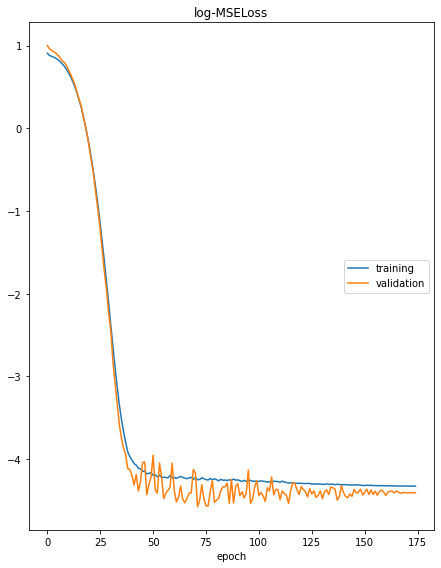

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.983% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.10/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.983% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
I

log-MSELoss
	training         	 (min:   -4.326, max:    0.908, cur:   -4.326)
	validation       	 (min:   -4.575, max:    1.001, cur:   -4.406)


In [83]:
#@title Generate forecast for any type of accident

accidents_ts = generate_forecast(accidents_df)

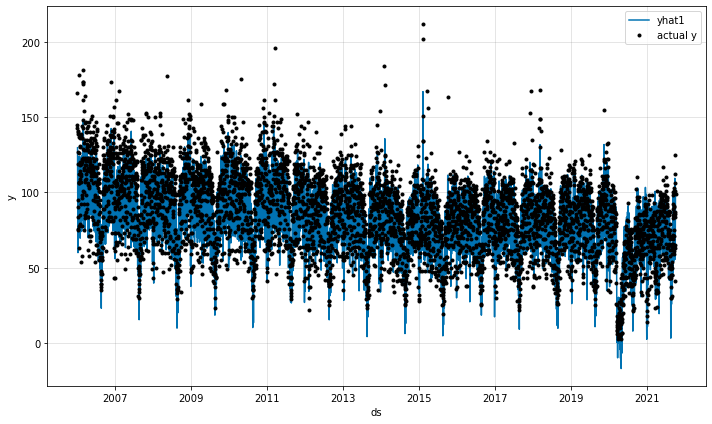

In [85]:
#@title Plot forecast for any type of accident

_ = accidents_ts.model.plot(accidents_ts.forecast)

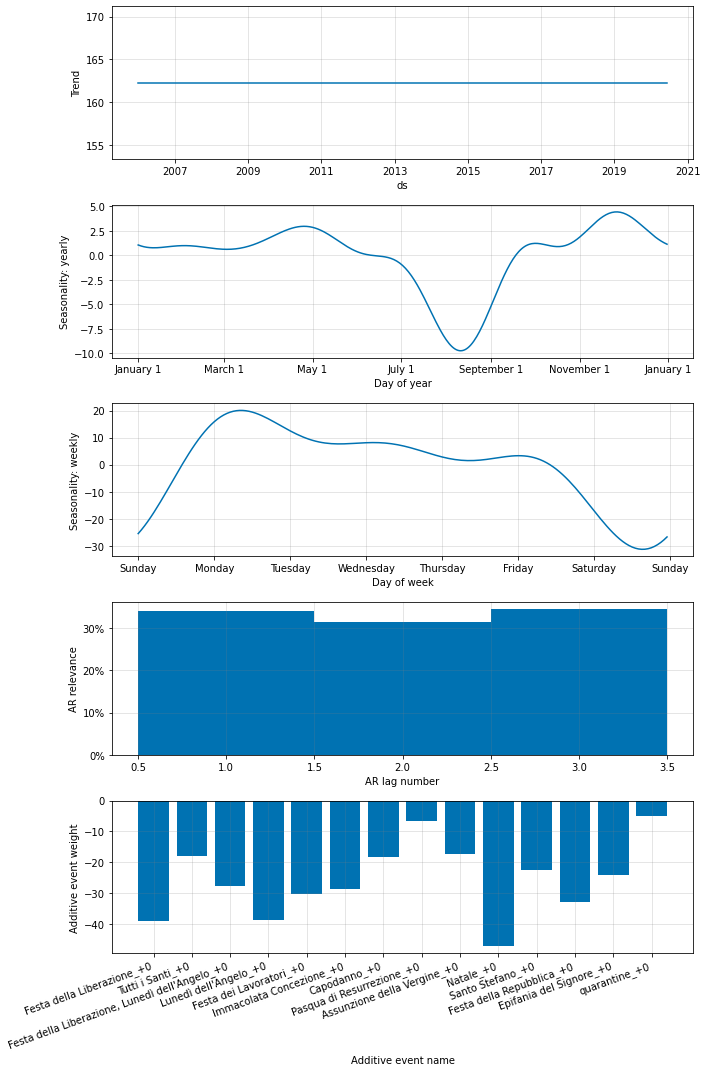

In [86]:
#@title Plot forecast parameters for any type of accident

_ = accidents_ts.model.plot_parameters()

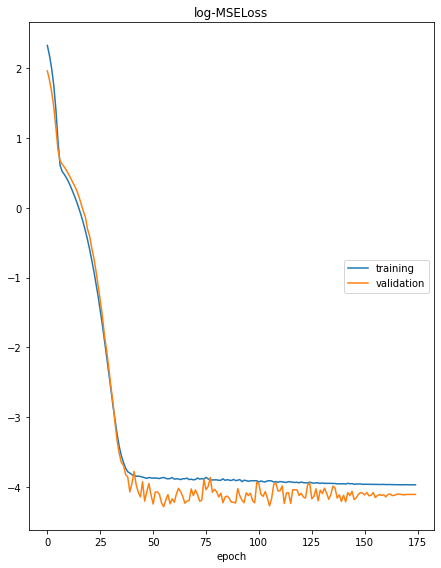

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.965% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.965% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.10/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.965% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.965% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
I

log-MSELoss
	training         	 (min:   -3.971, max:    2.326, cur:   -3.971)
	validation       	 (min:   -4.285, max:    1.961, cur:   -4.109)


In [87]:
#@title Generate forecast for accidents with injured

accidents_injured_ts = generate_forecast(accidents_df.filter(accidents_df['Injured'] == 1))

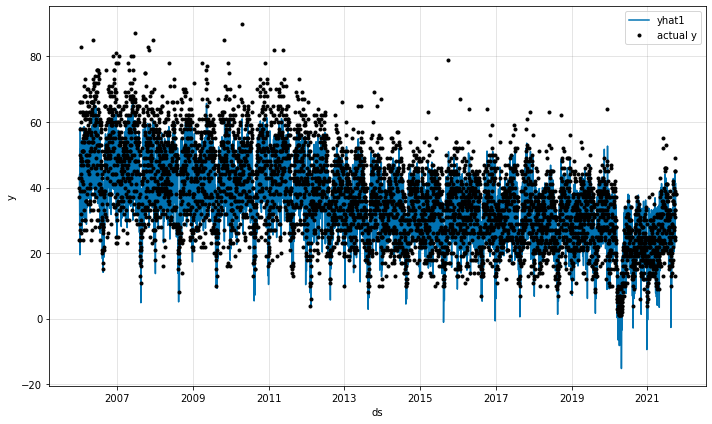

In [88]:
#@title Plot forecast for accidents with injured

_ = accidents_injured_ts.model.plot(accidents_injured_ts.forecast)

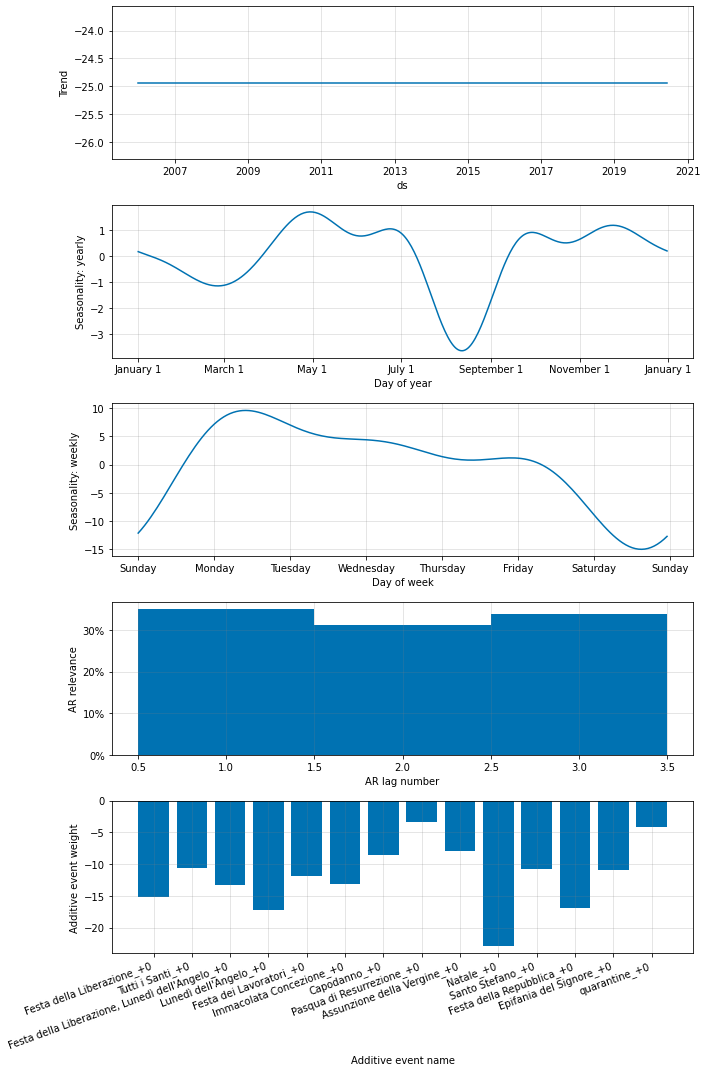

In [89]:
#@title Plot forecast parameters for accidents with injured

_ = accidents_injured_ts.model.plot_parameters()

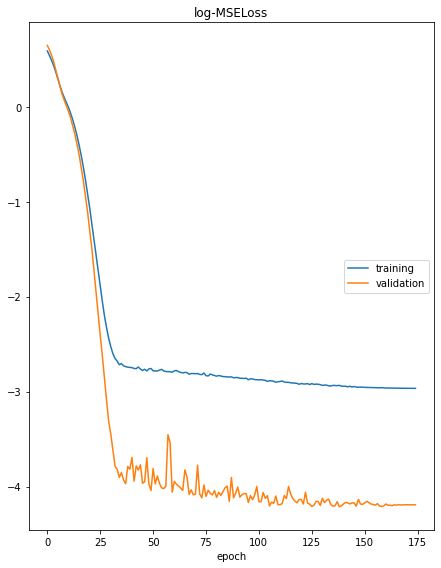

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 32.613% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 32.613% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.10/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 32.65% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 32.65% of the data.
WARNING - (

log-MSELoss
	training         	 (min:   -2.966, max:    0.587, cur:   -2.966)
	validation       	 (min:   -4.213, max:    0.646, cur:   -4.193)


In [94]:
accidents_deadly_ts = generate_forecast(accidents_df.filter(accidents_df['Deadly'] == 1), frequency='D')

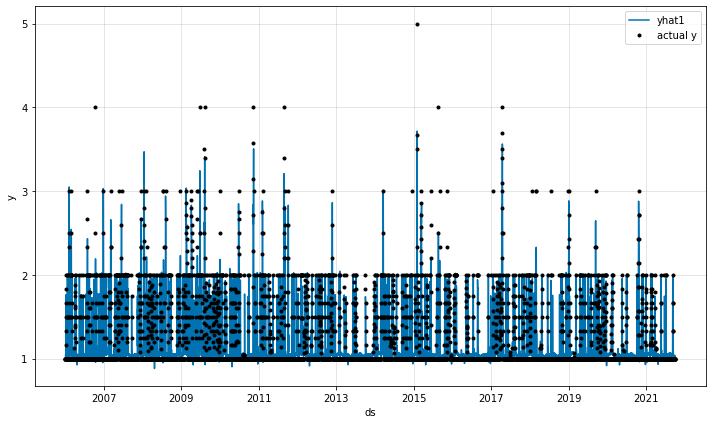

In [95]:
_ = accidents_deadly_ts.model.plot(accidents_deadly_ts.forecast)

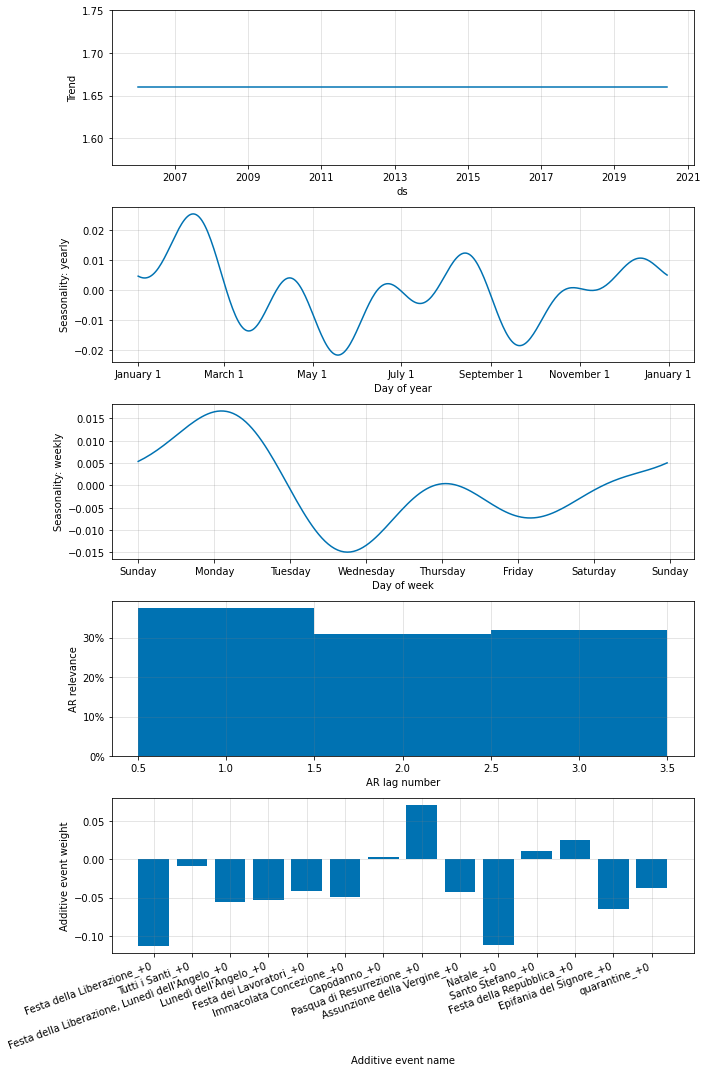

In [97]:
_ = accidents_deadly_ts.model.plot_parameters()

# Conclusions